<a href="https://colab.research.google.com/github/pschaldenbrand/StyleCLIPDraw/blob/master/Style_ClipDraw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Directions


1. Click "Connect" in the top right corner
2. Runtime -> Change runtime type -> Hardware accelerator -> GPU
3. Click the run button on "Pre Installation". This will install dependencies, it may take a while.
4. **Important:** Runtime -> Restart Runtime
5. Run the imports and function definition sections.
  - **Important:** The "Imports and Notebook Utilities" cell will print which GPU you have been assigned.  This notebook needs to be run with a T4, P4, P100, or V100 GPU (**K80 will not work**, unfortunately). You may have to restart the machine a few times until you get assigned a valid GPU (Runtime -> manage sessions -> terminate the session -> re-connect to new session).
6. Run the `style_clip_draw()` function with your own parameters. See the last few cells for examples

## StyleCLIPDraw Parameters

The style_clip_draw() function has many parameters to play with.  In the last few cells, you can see a few examples of the function in action.

```
def style_clip_draw(...):
    Perform StyleCLIPDraw using a given text prompt and style image
    args:
        prompt (str) : Text prompt to draw
        style_path(str) : Style image path or url
    kwargs:
        num_paths (int) : Number of brush strokes
        num_iter(int) : Number of optimization iterations
        max_width(float) : Maximum width of a brush stroke in pixels
        num_augs(int) : Number of image augmentations
        style_opt_freq(int) : How often to do style optimization. Low value is high frequency
        style_opt_iter(int) : How many iterations to do in the style optimization loop
        debug(bool) : Print intermediate canvases and losses for debugging
```

### Acknowledgement 
StyleCLIPDraw is built off of [CLIPDraw (Frans et al. 2021)](https://arxiv.org/pdf/2106.14843.pdf) [(Their code)](https://github.com/kvfrans/clipdraw)

In [ ]:
#@title Pre Installation {vertical-output: true}

import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = "+cu102"
elif CUDA_version == "11.0":
    torch_version_suffix = "+cu110"
elif CUDA_version == "11.1":
    torch_version_suffix = "+cu111"
elif CUDA_version == "11.2":
    torch_version_suffix = "+cu112"
else:
    torch_version_suffix = "+cu110"
# !pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html &> /dev/null
!pip install --upgrade torch

%cd /content/
!pip install svgwrite           &> /dev/null
!pip install svgpathtools       &> /dev/null
!pip install cssutils           &> /dev/null
!pip install numba              &> /dev/null
!pip install torch-tools        &> /dev/null
!pip install visdom             &> /dev/null

!git clone https://github.com/BachiLi/diffvg
%cd diffvg
# !ls
!git submodule update --init --recursive
!python setup.py install           &> /dev/null

!pip install ftfy regex tqdm       &> /dev/null
!pip install git+https://github.com/openai/CLIP.git --no-deps

**Runtime -> Restart Runtime**

You must restart the notebook for the installed packages to take effect

In [1]:
#@title Imports and Notebook Utilities {vertical-output: true}
%tensorflow_version 2.x

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob
import copy 
from tqdm import tqdm

from IPython.display import Image, HTML, clear_output
from tqdm import tqdm_notebook, tnrange

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    r = requests.get(url)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img = img.resize((max_size, max_size))
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))


def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

from torchvision import utils
def show_img(img):
    img = np.transpose(img, (1, 2, 0))
    img = np.clip(img, 0, 1)
    img = np.uint8(img * 254)
    # img = np.repeat(img, 4, axis=0)
    # img = np.repeat(img, 4, axis=1)
    pimg = PIL.Image.fromarray(img, mode="RGB")
    imshow(pimg)

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))


import torch

# torch.set_default_tensor_type('torch.cuda.FloatTensor')
# print("Torch version:", torch.__version__)

import pydiffvg
import skimage
import skimage.io
import random
import ttools.modules
import argparse
import math
import torchvision
import torchvision.transforms as transforms
import requests
from io import BytesIO


import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import PIL
from time import time

device = torch.device('cuda')


pydiffvg.set_print_timing(False)
# Use GPU if available
pydiffvg.set_use_gpu(torch.cuda.is_available())
pydiffvg.set_device(device)

%cd /content/diffvg/apps/
#

/content/diffvg/apps


In [ ]:
#@title Check GPU {vertical-output: true}
!nvidia-smi -L

print('\nThe above GPU must be a T4, P4, P100, or V100 GPU (K80 will not work, unfortunately)')
print('If the GPU is not valid, please restart the machine until a valid GPU is assigned:')
print('Runtime -> manage sessions -> terminate the session -> start a new session')

In [3]:
#@title Load CLIP {vertical-output: true}

# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import os
import clip
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR100

# Load the model
device = torch.device('cuda')
model, preprocess = clip.load('ViT-B/32', device, jit=False)

nouns = "aardvark abyssinian accelerator accordion account accountant acknowledgment acoustic acrylic act action active activity actor actress adapter addition address adjustment adult advantage advertisement advice afghanistan africa aftermath afternoon aftershave afterthought age agenda agreement air airbus airmail airplane airport airship alarm albatross alcohol algebra algeria alibi alley alligator alloy almanac alphabet alto aluminium aluminum ambulance america amount amusement anatomy anethesiologist anger angle angora animal anime ankle answer ant antarctica anteater antelope anthony anthropology apartment apology apparatus apparel appeal appendix apple appliance approval april aquarius arch archaeology archeology archer architecture area argentina argument aries arithmetic arm armadillo armchair armenian army arrow art ash ashtray asia asparagus asphalt asterisk astronomy athlete atm atom attack attempt attention attic attraction august aunt australia australian author authorisation authority authorization avenue babies baboon baby back backbone bacon badge badger bag bagel bagpipe bail bait baker bakery balance balinese ball balloon bamboo banana band bandana bangladesh bangle banjo bank bankbook banker bar barbara barber barge baritone barometer base baseball basement basin basket basketball bass bassoon bat bath bathroom bathtub battery battle bay beach bead beam bean bear beard beast beat beautician beauty beaver bed bedroom bee beech beef beer beet beetle beggar beginner begonia behavior belgian belief believe bell belt bench bengal beret berry bestseller betty bibliography bicycle bike bill billboard biology biplane birch bird birth birthday bit bite black bladder blade blanket blinker blizzard block blood blouse blow blowgun blue board boat bobcat body bolt bomb bomber bone bongo bonsai book bookcase booklet boot border botany bottle bottom boundary bow bowl bowling box boy bra brace bracket brain brake branch brand brandy brass brazil bread break breakfast breath brian brick bridge british broccoli brochure broker bronze brother brother-in-law brow brown brush bubble bucket budget buffer buffet bugle building bulb bull bulldozer bumper bun burglar burma burn burst bus bush business butane butcher butter button buzzard cabbage cabinet cable cactus cafe cake calculator calculus calendar calf call camel camera camp can canada canadian cancer candle cannon canoe canvas cap capital cappelletti capricorn captain caption car caravan carbon card cardboard cardigan care carnation carol carp carpenter carriage carrot cart cartoon case cast castanet cat catamaran caterpillar cathedral catsup cattle cauliflower cause caution cave c-clamp cd ceiling celery celeste cell cellar cello celsius cement cemetery cent centimeter century ceramic cereal certification chain chair chalk chance change channel character chard charles chauffeur check cheek cheese cheetah chef chemistry cheque cherries cherry chess chest chick chicken chicory chief child children chill chime chimpanzee chin china chinese chive chocolate chord christmas christopher chronometer church cicada cinema circle circulation cirrus citizenship city clam clarinet class claus clave clef clerk click client climb clipper cloakroom clock close closet cloth cloud cloudy clover club clutch coach coal coast coat cobweb cockroach cocktail cocoa cod coffee coil coin coke cold collar college collision colombia colon colony color colt column columnist comb comfort comic comma command commission committee community company comparison competition competitor composer composition computer condition condor cone confirmation conga congo conifer connection consonant continent control cook cooking copper copy copyright cord cork cormorant corn cornet correspondent cost cotton couch cougar cough country course court cousin cover cow cowbell crab crack cracker craftsman crate crawdad crayfish crayon cream creator creature credit creditor creek crib cricket crime criminal crocodile crocus croissant crook crop cross crow crowd crown crush cry cub cuban cucumber cultivator cup cupboard cupcake curler currency current curtain curve cushion custard customer cut cuticle cycle cyclone cylinder cymbal dad daffodil dahlia daisy damage dance dancer danger daniel dash dashboard database date daughter david day dead deadline deal death deborah debt debtor decade december decimal decision decrease dedication deer defense deficit degree delete delivery den denim dentist deodorant department deposit description desert design desire desk dessert destruction detail detective development dew diamond diaphragm dibble dictionary dietician difference digestion digger digital dill dime dimple dinghy dinner dinosaur diploma dipstick direction dirt disadvantage discovery discussion disease disgust dish distance distribution distributor diving division divorced dock doctor dog dogsled doll dollar dolphin domain donald donkey donna door dorothy double doubt downtown dragon dragonfly drain drake drama draw drawbridge drawer dream dredger dress dresser dressing drill drink drive driver driving drizzle drop drug drum dry dryer duck duckling dugout dungeon dust eagle ear earth earthquake ease east edge edger editor editorial education edward eel effect egg eggnog eggplant egypt eight elbow element elephant elizabeth ellipse emery employee employer encyclopedia end enemy energy engine engineer engineering english enquiry entrance environment epoch epoxy equinox equipment era error estimate ethernet ethiopia euphonium europe evening event examination example exchange exclamation exhaust ex-husband existence expansion experience expert explanation ex-wife eye eyebrow eyelash eyeliner face facilities fact factory fahrenheit fairies fall family fan fang farm farmer fat father father-in-law faucet fear feast feather feature february fedelini feedback feeling feet felony female fender ferry ferryboat fertilizer fiber fiberglass fibre fiction field fifth fight fighter file find fine finger fir fire fired fireman fireplace firewall fish fisherman flag flame flare flat flavor flax flesh flight flock flood floor flower flugelhorn flute fly foam fog fold font food foot football footnote force forecast forehead forest forgery fork form format fortnight foundation fountain fowl fox foxglove fragrance frame france freckle freeze freezer freighter french freon friction friday fridge friend frog front frost frown fruit fuel fur furniture galley gallon game gander garage garden garlic gas gasoline gate gateway gauge gazelle gear gearshift geese gemini gender geography geology geometry george geranium german germany ghana ghost giant giraffe girdle girl gladiolus glass glider gliding glockenspiel glove glue goal goat gold goldfish golf gondola gong good-bye goose gore-tex gorilla gosling government governor grade grain gram granddaughter grandfather grandmother grandson grape graphic grass grasshopper gray grease great-grandfather great-grandmother greece greek green grenade grey grill grip ground group grouse growth guarantee guatemalan guide guilty guitar gum gun gym gymnast hacksaw hail hair haircut half-brother half-sister halibut hall hallway hamburger hammer hamster hand handball handicap handle handsaw harbor hardboard hardcover hardhat hardware harmonica harmony harp hat hate hawk head headlight headline health hearing heart heat heaven hedge height helen helicopter helium hell helmet help hemp hen heron herring hexagon hill himalayan hip hippopotamus history hobbies hockey hoe hole holiday home honey hood hook hope horn horse hose hospital hot hour hourglass house hovercraft hub hubcap humidity humor hurricane hyacinth hydrant hydrofoil hydrogen hyena hygienic ice icebreaker icicle icon idea ikebana illegal imprisonment improvement impulse inch income increase index india indonesia industry ink innocent input insect instruction instrument insulation insurance interactive interest internet interviewer intestine invention inventory invoice iran iraq iris iron island israel italian italy jacket jaguar jail jam james january japan japanese jar jasmine jason jaw jeans jeep jeff jelly jellyfish jennifer jet jewel jogging john join joke joseph journey judge judo juice july jumbo jump jumper june jury justice jute kale kamikaze kangaroo karate karen kayak kendo kenneth kenya ketchup kettle kettledrum kevin key keyboard keyboarding kick kidney kilogram kilometer kimberly kiss kitchen kite kitten kitty knee knickers knife knight knot knowledge kohlrabi korean laborer lace ladybug lake lamb lamp lan land landmine language larch lasagna latency latex lathe laugh laundry laura law lawyer layer lead leaf learning leather leek leg legal lemonade lentil leo leopard letter lettuce level libra library license lier lift light lightning lilac lily limit linda line linen link lion lip lipstick liquid liquor lisa list literature litter liver lizard llama loaf loan lobster lock locket locust look loss lotion love low lumber lunch lunchroom lung lunge lute luttuce lycra lynx lyocell lyre lyric macaroni machine macrame magazine magic magician maid mail mailbox mailman makeup malaysia male mall mallet man manager mandolin manicure manx map maple maraca marble march margaret margin maria marimba mark mark market married mary mascara mask mass match math mattock may mayonnaise meal measure meat mechanic medicine meeting melody memory men menu mercury message metal meteorology meter methane mexican mexico mice michael michelle microwave middle mile milk milkshake millennium millimeter millisecond mimosa mind mine minibus mini-skirt minister mint minute mirror missile mist mistake mitten moat modem mole mom monday money monkey month moon morning morocco mosque mosquito mother mother-in-law motion motorboat motorcycle mountain mouse moustache mouth move multi-hop multimedia muscle museum music musician mustard myanmar nail name nancy napkin narcissus nation neck need needle neon nepal nephew nerve nest net network news newsprint newsstand nic nickel niece nigeria night nitrogen node noise noodle north north america north korea norwegian nose note notebook notify novel november number numeric nurse nut nylon oak oatmeal objective oboe observation occupation ocean ocelot octagon octave october octopus odometer offence offer office oil okra olive onion open opera operation ophthalmologist opinion option orange orchestra orchid order organ organisation organization ornament ostrich otter ounce output outrigger oval oven overcoat owl owner ox oxygen oyster package packet page pail pain paint pair pajama pakistan palm pamphlet pan pancake pancreas panda pansy panther panties pantry pants panty pantyhose paper paperback parade parallelogram parcel parent parentheses park parrot parsnip part particle partner partridge party passbook passenger passive pasta paste pastor pastry patch path patient patio patricia paul payment pea peace peak peanut pear pedestrian pediatrician peen peer-to-peer pelican pen penalty pencil pendulum pentagon peony pepper perch perfume period periodical peripheral permission persian person peru pest pet pharmacist pheasant philippines philosophy phone physician piano piccolo pickle picture pie pig pigeon pike pillow pilot pimple pin pine ping pink pint pipe pisces pizza place plain plane planet plant plantation plaster plasterboard plastic plate platinum play playground playroom pleasure plier plot plough plow plywood pocket poet point poison poland police policeman polish politician pollution polo polyester pond popcorn poppy population porch porcupine port porter position possibility postage postbox pot potato poultry pound powder power precipitation preface prepared pressure price priest print printer prison probation process processing produce product production professor profit promotion propane property prose prosecution protest protocol pruner psychiatrist psychology ptarmigan puffin pull puma pump pumpkin punch punishment puppy purchase purple purpose push pvc pyjama pyramid quail quality quart quarter quartz queen question quicksand quiet quill quilt quince quit quiver quotation rabbi rabbit racing radar radiator radio radish raft rail railway rain rainbow raincoat rainstorm rake ramie random range rat rate raven ravioli ray rayon reaction reading reason receipt recess record recorder rectangle red reduction refrigerator refund regret reindeer relation relative religion relish reminder repair replace report representative request resolution respect responsibility rest restaurant result retailer revolve revolver reward rhinoceros rhythm rice richard riddle rifle ring rise risk river riverbed road roadway roast robert robin rock rocket rod roll romania romanian ronald roof room rooster root rose rotate route router rowboat rub rubber rugby rule run russia russian rutabaga ruth sack sagittarius sail sailboat sailor salad salary sale salesman salmon salt sampan samurai sand sandra sandwich santa sarah sardine satin saturday sauce saudi arabia sausage save saw saxophone scale scallion scanner scarecrow scarf scene scent schedule school science scissors scooter scorpio scorpion scraper screen screw screwdriver sea seagull seal seaplane search seashore season seat second secretary secure security seed seeder segment select selection self semicircle semicolon sense sentence separated september servant server session sex shade shadow shake shallot shame shampoo shape share shark sharon shears sheep sheet shelf shell shield shingle ship shirt shock shoe shoemaker shop shorts shoulder shovel show shrimp shrine siamese siberian side sideboard sidecar sidewalk sign signature silica silk silver sing singer single sink sister sister-in-law size skate skiing skill skin skirt sky slash slave sled sleep sleet slice slime slip slipper slope smash smell smile smoke snail snake sneeze snow snowboarding snowflake snowman snowplow snowstorm soap soccer society sociology sock soda sofa softball softdrink software soil soldier son song soprano sort sound soup sousaphone south africa south america south korea soy soybean space spade spaghetti spain spandex spark sparrow spear specialist speedboat sphere sphynx spider spike spinach spleen sponge spoon spot spring sprout spruce spy square squash squid squirrel stage staircase stamp star start starter state statement station statistic steam steel stem step step-aunt step-brother stepdaughter step-daughter step-father step-grandfather step-grandmother stepmother step-mother step-sister stepson step-son step-uncle steven stew stick stinger stitch stock stocking stomach stone stool stop stopsign stopwatch store storm story stove stranger straw stream street streetcar stretch string structure study sturgeon submarine substance subway success sudan suede sugar suggestion suit summer sun sunday sundial sunflower sunshine supermarket supply support surfboard surgeon surname surprise susan sushi swallow swamp swan sweater sweatshirt sweatshop swedish sweets swim swimming swing swiss switch sword swordfish sycamore syria syrup system table tablecloth tabletop tachometer tadpole tail tailor taiwan talk tank tanker tanzania target taste taurus tax taxi taxicab tea teacher teaching team technician teeth television teller temper temperature temple tempo tendency tennis tenor tent territory test text textbook texture thailand theater theory thermometer thing thistle thomas thought thread thrill throat throne thumb thunder thunderstorm thursday ticket tie tiger tights tile timbale time timer timpani tin tip tire titanium title toad toast toe toenail toilet tomato tom-tom ton tongue tooth toothbrush toothpaste top tornado tortellini tortoise touch tower town toy tractor trade traffic trail train tramp transaction transmission transport trapezoid tray treatment tree trial triangle trick trigonometry trip trombone trouble trousers trout trowel truck trumpet trunk t-shirt tsunami tub tuba tuesday tugboat tulip tuna tune turkey turkey turkish turn turnip turnover turret turtle tv twig twilight twine twist typhoon tyvek uganda ukraine ukrainian umbrella uncle underclothes underpants undershirt underwear unit united kingdom unshielded use utensil uzbekistan vacation vacuum valley value van vase vault vegetable vegetarian veil vein velvet venezuela venezuelan verdict vermicelli verse vessel vest veterinarian vibraphone vietnam view vinyl viola violet violin virgo viscose vise vision visitor voice volcano volleyball voyage vulture waiter waitress walk wall wallaby wallet walrus war warm wash washer wasp waste watch watchmaker water waterfall wave wax way wealth weapon weasel weather wedge wednesday weed weeder week weight whale wheel whip whiskey whistle white wholesaler whorl wilderness william willow wind windchime window windscreen windshield wine wing winter wire wish witch withdrawal witness wolf woman women wood wool woolen word work workshop worm wound wrecker wren wrench wrinkle wrist writer xylophone yacht yak yam yard yarn year yellow yew yogurt yoke yugoslavian zebra zephyr zinc zipper zone zoo zoology"
nouns = nouns.split(" ")
noun_prompts = ["a drawing of a " + x for x in nouns]

# Calculate features
with torch.no_grad():
    nouns_features = model.encode_text(torch.cat([clip.tokenize(noun_prompts).to(device)]))
# print(nouns_features.shape, nouns_features.dtype)


100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 68.7MiB/s]


In [4]:
#@title Style Loss and Drawing Functions {vertical-output: true}
def pil_resize_long_edge_to(pil, trg_size):
  short_w = pil.width < pil.height
  ar_resized_long = (trg_size / pil.height) if short_w else (trg_size / pil.width)
  resized = pil.resize((int(pil.width * ar_resized_long), int(pil.height * ar_resized_long)), PIL.Image.BICUBIC)
  return resized


class Vgg16_Extractor(nn.Module):
    def __init__(self, space):
        super().__init__()
        self.vgg_layers = models.vgg16(pretrained=True).features

        for param in self.parameters():
            param.requires_grad = False
        self.capture_layers = [1,3,6,8,11,13,15,22,29]
        self.space = space
        
    def forward_base(self, x):
        feat = [x]
        for i in range(max(self.capture_layers)+1):
            x = self.vgg_layers[i](x)
            if i in self.capture_layers: feat.append(x)
        return feat

    def forward(self, x):
        if self.space != 'vgg':
            x = (x + 1.) / 2.
            x = x - (torch.Tensor([0.485, 0.456, 0.406]).to(x.device).view(1, -1, 1, 1))
            x = x / (torch.Tensor([0.229, 0.224, 0.225]).to(x.device).view(1, -1, 1, 1))
        feat = self.forward_base(x)
        return feat
    
    def forward_samples_hypercolumn(self, X, samps=100):
        feat = self.forward(X)

        xx,xy = np.meshgrid(np.arange(X.shape[2]), np.arange(X.shape[3]))
        xx = np.expand_dims(xx.flatten(),1)
        xy = np.expand_dims(xy.flatten(),1)
        xc = np.concatenate([xx,xy],1)
        
        samples = min(samps,xc.shape[0])

        np.random.shuffle(xc)
        xx = xc[:samples,0]
        yy = xc[:samples,1]

        feat_samples = []
        for i in range(len(feat)):

            layer_feat = feat[i]

            # hack to detect lower resolution
            if i>0 and feat[i].size(2) < feat[i-1].size(2):
                xx = xx/2.0
                yy = yy/2.0

            xx = np.clip(xx, 0, layer_feat.shape[2]-1).astype(np.int32)
            yy = np.clip(yy, 0, layer_feat.shape[3]-1).astype(np.int32)

            features = layer_feat[:,:, xx[range(samples)], yy[range(samples)]]
            feat_samples.append(features.clone().detach())

        feat = torch.cat(feat_samples,1)
        return feat
    
# Tensor and PIL utils

def pil_loader(path):
    with open(path, 'rb') as f:
        img = PIL.Image.open(f)
        return img.convert('RGB')

def pil_loader_internet(url):
    response = requests.get(url)
    img = PIL.Image.open(BytesIO(response.content))
    return img.convert('RGB')

def tensor_resample(tensor, dst_size, mode='bilinear'):
    return F.interpolate(tensor, dst_size, mode=mode, align_corners=False)

def pil_resize_short_edge_to(pil, trg_size):
    short_w = pil.width < pil.height
    ar_resized_short = (trg_size / pil.width) if short_w else (trg_size / pil.height)
    resized = pil.resize((int(pil.width * ar_resized_short), int(pil.height * ar_resized_short)), PIL.Image.BICUBIC)
    return resized

def pil_resize_long_edge_to(pil, trg_size):
    short_w = pil.width < pil.height
    ar_resized_long = (trg_size / pil.height) if short_w else (trg_size / pil.width)
    resized = pil.resize((int(pil.width * ar_resized_long), int(pil.height * ar_resized_long)), PIL.Image.BICUBIC)
    return resized

def np_to_pil(npy):
    return PIL.Image.fromarray(npy.astype(np.uint8))

def pil_to_np(pil):
    return np.array(pil)

def tensor_to_np(tensor, cut_dim_to_3=True):
    if len(tensor.shape) == 4:
        if cut_dim_to_3:
            tensor = tensor[0]
        else:
            return tensor.data.cpu().numpy().transpose((0, 2, 3, 1))
    return tensor.data.cpu().numpy().transpose((1,2,0))

def np_to_tensor(npy, space):
    if space == 'vgg':
        return np_to_tensor_correct(npy)
    return (torch.Tensor(npy.astype(np.float) / 127.5) - 1.0).permute((2,0,1)).unsqueeze(0)

def np_to_tensor_correct(npy):
    pil = np_to_pil(npy)
    transform = transforms.Compose([transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(pil).unsqueeze(0)

# Laplacian Pyramid

def laplacian(x):
    # x - upsample(downsample(x))
    return x - tensor_resample(tensor_resample(x, [x.shape[2] // 2, x.shape[3] // 2]), [x.shape[2], x.shape[3]])

def make_laplace_pyramid(x, levels):
    pyramid = []
    current = x
    for i in range(levels):
        pyramid.append(laplacian(current))
        current = tensor_resample(current, (max(current.shape[2] // 2,1), max(current.shape[3] // 2,1)))
    pyramid.append(current)
    return pyramid

def fold_laplace_pyramid(pyramid):
    current = pyramid[-1]
    for i in range(len(pyramid)-2, -1, -1): # iterate from len-2 to 0
        up_h, up_w = pyramid[i].shape[2], pyramid[i].shape[3]
        current = pyramid[i] + tensor_resample(current, (up_h,up_w))
    return current

def sample_indices(feat_content, feat_style):
    indices = None
    const = 128**2 # 32k or so
    feat_dims = feat_style.shape[1]
    big_size = feat_content.shape[2] * feat_content.shape[3] # num feaxels

    stride_x = int(max(math.floor(math.sqrt(big_size//const)),1))
    offset_x = np.random.randint(stride_x)
    stride_y = int(max(math.ceil(math.sqrt(big_size//const)),1))
    offset_y = np.random.randint(stride_y)
    xx, xy = np.meshgrid(np.arange(feat_content.shape[2])[offset_x::stride_x], np.arange(feat_content.shape[3])[offset_y::stride_y] )

    xx = xx.flatten()
    xy = xy.flatten()
    return xx, xy

def spatial_feature_extract(feat_result, feat_content, xx, xy):
    l2, l3 = [], []
    device = feat_result[0].device

    # for each extracted layer
    for i in range(len(feat_result)):
        fr = feat_result[i]
        fc = feat_content[i]

        # hack to detect reduced scale
        if i>0 and feat_result[i-1].size(2) > feat_result[i].size(2):
            xx = xx/2.0
            xy = xy/2.0

        # go back to ints and get residual
        xxm = np.floor(xx).astype(np.float32)
        xxr = xx - xxm

        xym = np.floor(xy).astype(np.float32)
        xyr = xy - xym

        # do bilinear resample
        w00 = torch.from_numpy((1.-xxr)*(1.-xyr)).float().view(1, 1, -1, 1).to(device)
        w01 = torch.from_numpy((1.-xxr)*xyr).float().view(1, 1, -1, 1).to(device)
        w10 = torch.from_numpy(xxr*(1.-xyr)).float().view(1, 1, -1, 1).to(device)
        w11 = torch.from_numpy(xxr*xyr).float().view(1, 1, -1, 1).to(device)

        xxm = np.clip(xxm.astype(np.int32),0,fr.size(2)-1)
        xym = np.clip(xym.astype(np.int32),0,fr.size(3)-1)

        s00 = xxm*fr.size(3)+xym
        s01 = xxm*fr.size(3)+np.clip(xym+1,0,fr.size(3)-1)
        s10 = np.clip(xxm+1,0,fr.size(2)-1)*fr.size(3)+(xym)
        s11 = np.clip(xxm+1,0,fr.size(2)-1)*fr.size(3)+np.clip(xym+1,0,fr.size(3)-1)

        fr = fr.view(1,fr.size(1),fr.size(2)*fr.size(3),1)
        fr = fr[:,:,s00,:].mul_(w00).add_(fr[:,:,s01,:].mul_(w01)).add_(fr[:,:,s10,:].mul_(w10)).add_(fr[:,:,s11,:].mul_(w11))

        fc = fc.view(1,fc.size(1),fc.size(2)*fc.size(3),1)
        fc = fc[:,:,s00,:].mul_(w00).add_(fc[:,:,s01,:].mul_(w01)).add_(fc[:,:,s10,:].mul_(w10)).add_(fc[:,:,s11,:].mul_(w11))

        l2.append(fr)
        l3.append(fc)

    x_st = torch.cat([li.contiguous() for li in l2],1)
    c_st = torch.cat([li.contiguous() for li in l3],1)

    xx = torch.from_numpy(xx).view(1,1,x_st.size(2),1).float().to(device)
    yy = torch.from_numpy(xy).view(1,1,x_st.size(2),1).float().to(device)
    
    x_st = torch.cat([x_st,xx,yy],1)
    c_st = torch.cat([c_st,xx,yy],1)
    return x_st, c_st

def pairwise_distances_cos(x, y):
    x_norm = torch.sqrt((x**2).sum(1).view(-1, 1))
    y_t = torch.transpose(y, 0, 1)
    y_norm = torch.sqrt((y**2).sum(1).view(1, -1))
    dist = 1.-torch.mm(x, y_t)/x_norm/y_norm
    return dist

def pairwise_distances_sq_l2(x, y):
    x_norm = (x**2).sum(1).view(-1, 1)
    y_t = torch.transpose(y, 0, 1)
    y_norm = (y**2).sum(1).view(1, -1)
    dist = x_norm + y_norm - 2.0 * torch.mm(x, y_t)
    return torch.clamp(dist, 1e-5, 1e5)/x.size(1)

def distmat(x, y, cos_d=True):
    if cos_d:
        M = pairwise_distances_cos(x, y)
    else:
        M = torch.sqrt(pairwise_distances_sq_l2(x, y))
    return M

def content_loss(feat_result, feat_content):
    d = feat_result.size(1)

    X = feat_result.transpose(0,1).contiguous().view(d,-1).transpose(0,1)
    Y = feat_content.transpose(0,1).contiguous().view(d,-1).transpose(0,1)

    Y = Y[:,:-2]
    X = X[:,:-2]
    # X = X.t()
    # Y = Y.t()

    Mx = distmat(X, X)
    Mx = Mx#/Mx.sum(0, keepdim=True)

    My = distmat(Y, Y)
    My = My#/My.sum(0, keepdim=True)

    d = torch.abs(Mx-My).mean()# * X.shape[0]
    return d

def rgb_to_yuv(rgb):
    C = torch.Tensor([[0.577350,0.577350,0.577350],[-0.577350,0.788675,-0.211325],[-0.577350,-0.211325,0.788675]]).to(rgb.device)
    yuv = torch.mm(C,rgb)
    return yuv

def style_loss(X, Y, cos_d=True):
    d = X.shape[1]

    if d == 3:
        X = rgb_to_yuv(X.transpose(0,1).contiguous().view(d,-1)).transpose(0,1)
        Y = rgb_to_yuv(Y.transpose(0,1).contiguous().view(d,-1)).transpose(0,1)
    else:
        X = X.transpose(0,1).contiguous().view(d,-1).transpose(0,1)
        Y = Y.transpose(0,1).contiguous().view(d,-1).transpose(0,1)

    # Relaxed EMD
    CX_M = distmat(X, Y, cos_d=True)

    if d==3: CX_M = CX_M + distmat(X, Y, cos_d=False)

    m1, m1_inds = CX_M.min(1)
    m2, m2_inds = CX_M.min(0)

    remd = torch.max(m1.mean(), m2.mean())

    return remd

def moment_loss(X, Y, moments=[1,2]):
    loss = 0.
    X = X.squeeze().t()
    Y = Y.squeeze().t()

    mu_x = torch.mean(X, 0, keepdim=True)
    mu_y = torch.mean(Y, 0, keepdim=True)
    mu_d = torch.abs(mu_x - mu_y).mean()

    if 1 in moments:
        # print(mu_x.shape)
        loss = loss + mu_d

    if 2 in moments:
        X_c = X - mu_x
        Y_c = Y - mu_y
        X_cov = torch.mm(X_c.t(), X_c) / (X.shape[0] - 1)
        Y_cov = torch.mm(Y_c.t(), Y_c) / (Y.shape[0] - 1)

        # print(X_cov.shape)
        # exit(1)

        D_cov = torch.abs(X_cov - Y_cov).mean()
        loss = loss + D_cov

    return loss


def calculate_loss(feat_result, feat_content, feat_style, indices, content_weight, moment_weight=1.0):
  # spatial feature extract
  num_locations = 1024
  spatial_result, spatial_content = spatial_feature_extract(feat_result, feat_content, indices[0][:num_locations], indices[1][:num_locations])
  # loss_content = content_loss(spatial_result, spatial_content)

  d = feat_style.shape[1]
  spatial_style = feat_style.view(1, d, -1, 1)
  feat_max = d#3+2*64+128*2+256*3+512*2 # (sum of all extracted channels)

  loss_remd = style_loss(spatial_result[:, :feat_max, :, :], spatial_style[:, :feat_max, :, :])

  loss_moment = moment_loss(spatial_result[:,:-2,:,:], spatial_style, moments=[1,2]) # -2 is so that it can fit?
  # palette matching
  content_weight_frac = 1./max(content_weight,1.)
  loss_moment += content_weight_frac * style_loss(spatial_result[:,:3,:,:], spatial_style[:,:3,:,:])
  
  loss_style = loss_remd + moment_weight * loss_moment
  # print(f'Style: {loss_style.item():.3f}, Content: {loss_content.item():.3f}')

  style_weight = 1.0 + moment_weight
  loss_total = (loss_style) / (content_weight + style_weight)
  return loss_total

def get_image_augmentation(use_normalized_clip):
    augment_trans = transforms.Compose([
        transforms.RandomPerspective(fill=1, p=1, distortion_scale=0.5),
        transforms.RandomResizedCrop(224, scale=(0.7,0.9)),
    ])

    if use_normalized_clip:
        augment_trans = transforms.Compose([
        transforms.RandomPerspective(fill=1, p=1, distortion_scale=0.5),
        transforms.RandomResizedCrop(224, scale=(0.7,0.9)),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    ])
    return augment_trans

def initialize_curves(num_paths, canvas_width, canvas_height):
    shapes = []
    shape_groups = []
    for i in range(num_paths):
        num_segments = random.randint(1, 3)
        num_control_points = torch.zeros(num_segments, dtype = torch.int32) + 2
        points = []
        p0 = (random.random(), random.random())
        points.append(p0)
        for j in range(num_segments):
            radius = 0.1
            p1 = (p0[0] + radius * (random.random() - 0.5), p0[1] + radius * (random.random() - 0.5))
            p2 = (p1[0] + radius * (random.random() - 0.5), p1[1] + radius * (random.random() - 0.5))
            p3 = (p2[0] + radius * (random.random() - 0.5), p2[1] + radius * (random.random() - 0.5))
            points.append(p1)
            points.append(p2)
            points.append(p3)
            p0 = p3
        points = torch.tensor(points)
        points[:, 0] *= canvas_width
        points[:, 1] *= canvas_height
        path = pydiffvg.Path(num_control_points = num_control_points, points = points, stroke_width = torch.tensor(1.0), is_closed = False)
        shapes.append(path)
        path_group = pydiffvg.ShapeGroup(shape_ids = torch.tensor([len(shapes) - 1]), fill_color = None, stroke_color = torch.tensor([random.random(), random.random(), random.random(), random.random()]))
        shape_groups.append(path_group)
    return shapes, shape_groups

def render_drawing(shapes, shape_groups,\
                   canvas_width, canvas_height, n_iter, save=False):
    scene_args = pydiffvg.RenderFunction.serialize_scene(\
        canvas_width, canvas_height, shapes, shape_groups)
    render = pydiffvg.RenderFunction.apply
    img = render(canvas_width, canvas_height, 2, 2, n_iter, None, *scene_args)
    img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = pydiffvg.get_device()) * (1 - img[:, :, 3:4])        
    if save:
        pydiffvg.imwrite(img.cpu(), '/content/res/iter_{}.png'.format(int(n_iter)), gamma=1.0)
    img = img[:, :, :3]
    img = img.unsqueeze(0)
    img = img.permute(0, 3, 1, 2) # NHWC -> NCHW
    return img

def render_scaled(shapes, shape_groups, original_height, original_width, 
                  scale_factor=4, t=1):
    '''
        Scale the size of the rendered image
    '''
    with torch.no_grad():
        shapes_resized = copy.deepcopy(shapes)
        for i in range(len(shapes)):
            shapes_resized[i].stroke_width = shapes[i].stroke_width * scale_factor
            for j in range(len(shapes[i].points)):
                shapes_resized[i].points[j] = shapes[i].points[j] * scale_factor
        img = render_drawing(shapes_resized, shape_groups, 
                             int(original_width*scale_factor), int(original_height*scale_factor), t)
        return img

In [5]:
#@title style_clip_draw() Definition (Fast Version)

def style_clip_draw(prompt, style_path, \
                    num_paths=256, max_width=50,\
                    num_augs=4,
                    neg_prompt=None, neg_prompt_2=None,\
                    use_normalized_clip=True,
                    debug=False):
    '''
    Perform StyleCLIPDraw using a given text prompt and style image. Fast version.
    args:
        prompt (str) : Text prompt to draw
        style_path(str) : Style image path or url
    kwargs:
        num_paths (int) : Number of brush strokes
        max_width(float) : Maximum width of a brush stroke in pixels
        num_augs(int) : Number of image augmentations
        neg_prompt(str) : Negative prompt. None if you don't want it
        neg_prompt_2(str) : Negative prompt. None if you don't want it
        use_normalized_clip(bool)
        debug(bool) : Print intermediate canvases and losses for debugging
    return
        np.ndarray(canvas_height, canvas_width, 3)
    '''
    text_input = clip.tokenize(prompt).to(device)

    if neg_prompt is not None: text_input_neg1 = clip.tokenize(neg_prompt).to(device)
    if neg_prompt_2 is not None: text_input_neg2 = clip.tokenize(neg_prompt_2).to(device)

    # Calculate features
    with torch.no_grad():
        text_features = model.encode_text(text_input)
        if neg_prompt is not None: text_features_neg1 = model.encode_text(text_input_neg1)
        if neg_prompt_2 is not None: text_features_neg2 = model.encode_text(text_input_neg2)

    canvas_width, canvas_height = 224, 224

    # Image Augmentation Transformation
    augment_trans = get_image_augmentation(use_normalized_clip)

    # Initialize Random Curves
    shapes, shape_groups = initialize_curves(num_paths, canvas_width, canvas_height)

    points_vars = []
    stroke_width_vars = []
    color_vars = []
    for path in shapes:
        path.points.requires_grad = True
        points_vars.append(path.points)
        path.stroke_width.requires_grad = True
        stroke_width_vars.append(path.stroke_width)
    for group in shape_groups:
        group.stroke_color.requires_grad = True
        color_vars.append(group.stroke_color)

    # Optimizers
    points_optim_style = torch.optim.RMSprop(points_vars, lr=0.1*3)
    width_optim_style = torch.optim.RMSprop(stroke_width_vars, lr=0.1*3)
    color_optim_style = torch.optim.RMSprop(color_vars, lr=0.01*3)

    style_pil = pil_loader(style_path) if os.path.exists(style_path) else pil_loader_internet(style_path)
    style_pil = pil_resize_long_edge_to(style_pil, canvas_width)
    style_np = pil_to_np(style_pil)
    style = (np_to_tensor(style_np, "normal").to(device)+1)/2
    extractor = Vgg16_Extractor(space="normal").to(device)

    # Extract style features from style image
    feat_style = None
    for i in range(5):
        with torch.no_grad():
        # r is region of interest (mask)
            feat_e = extractor.forward_samples_hypercolumn(style, samps=1000)
            feat_style = feat_e if feat_style is None else torch.cat((feat_style, feat_e), dim=2)
    
    best_content_loss, its_since_best = 9999999, 0

    # Run the main optimization loop
    #for t in range(num_iter) if debug else tqdm(range(num_iter)):
    t = 0
    num_iter=500 
    pbar = tqdm(total=num_iter)
    while(t < num_iter):
        # for g in points_optim_style.param_groups + width_optim_style.param_groups + color_optim_style.param_groups:
        #     g['lr'] *= 0.98

        points_optim_style.zero_grad()
        width_optim_style.zero_grad()
        color_optim_style.zero_grad()

        img = render_drawing(shapes, shape_groups, canvas_width, canvas_height, t, save=(t % 5 == 0))

        loss = 0
        img_augs = []
        for n in range(num_augs):
            img_augs.append(augment_trans(img))
        im_batch = torch.cat(img_augs)
        image_features = model.encode_image(im_batch)
        for n in range(num_augs):
            loss -= torch.cosine_similarity(text_features, image_features[n:n+1], dim=1)
            if neg_prompt is not None: loss += torch.cosine_similarity(text_features_neg1, image_features[n:n+1], dim=1) * 0.3
            if neg_prompt_2 is not None: loss += torch.cosine_similarity(text_features_neg2, image_features[n:n+1], dim=1) * 0.3

        its_since_best += 1
        if loss.item() < best_content_loss:
            best_content_loss, its_since_best = loss.item(), 0

        if its_since_best == 50:
            t =  max(t, int(0.8*num_iter))

        # Do style optimization 
        feat_content = extractor(img)
        xx, xy = sample_indices(feat_content[0], feat_style) # 0 to sample over first layer extracted
        np.random.shuffle(xx)
        np.random.shuffle(xy)

        loss /= num_augs
        if t > 0.8*num_iter:
            loss *= .1 # Very little content loss at the end
        loss += calculate_loss(feat_content, feat_content, feat_style, [xx, xy], 0)
        
        loss.backward()
        points_optim_style.step()
        width_optim_style.step()
        color_optim_style.step()

        for path in shapes:
            path.stroke_width.data.clamp_(1.0, max_width)
        for group in shape_groups:
            group.stroke_color.data.clamp_(0.0, 1.0)

        t += 1
        pbar.update(1)

        if t % 20 == 0 and debug:
            img = render_scaled(shapes, shape_groups, canvas_width, canvas_height, t=t, scale_factor=2)
            show_img(img.detach().cpu().numpy()[0])
            # show_img(torch.cat([img.detach(), img_aug.detach()], axis=3).cpu().numpy()[0])
            print('render loss:', loss.item())
            print('iteration:', t)
    pbar.close()
    return render_scaled(shapes, shape_groups, canvas_width, canvas_height, t=t, scale_factor=2).detach().cpu().numpy()[0]#, \
            #render_scaled(shapes, shape_groups, canvas_width, canvas_height, t=t, scale_factor=2).detach()


 62%|██████▏   | 308/500 [01:13<00:45,  4.20it/s]


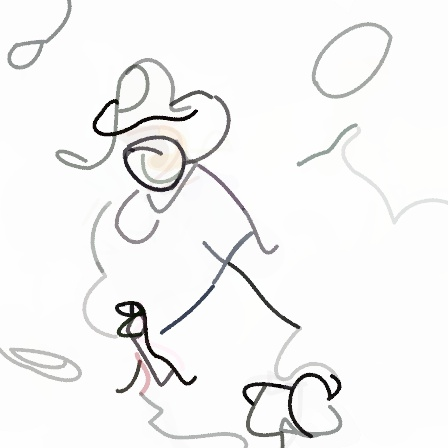

In [ ]:
img = style_clip_draw('A man is walking the dog', 'https://raw.githubusercontent.com/pschaldenbrand/StyleCLIPDraw/master/images/bear.jpg')
show_img(img)

 78%|███████▊  | 391/500 [01:39<00:27,  3.94it/s]


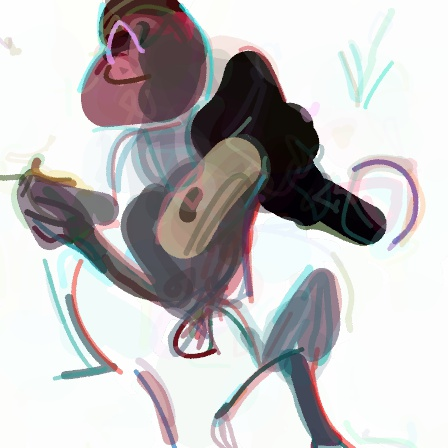

In [ ]:
img = style_clip_draw('A monkey playing guitar', 'https://raw.githubusercontent.com/pschaldenbrand/StyleCLIPDraw/master/images/tiktok.JPG')
show_img(img)

 80%|████████  | 401/500 [01:53<00:28,  3.53it/s]


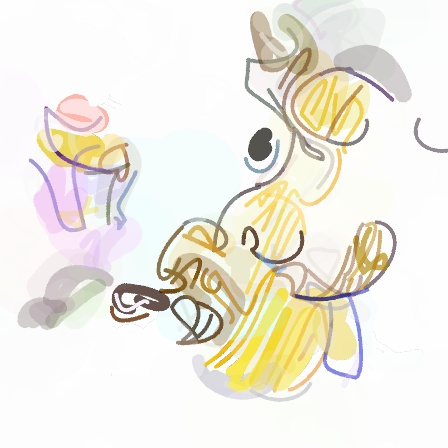

In [ ]:
img = style_clip_draw('A horse eating a cupcake', 'https://raw.githubusercontent.com/pschaldenbrand/StyleCLIPDraw/master/images/lion.jpg')
show_img(img)

### Run it 4 times and take the best result
Sometimes StyleClipDraw gets stuck in local minima that don't look great. Use CLIP to select the best result after running it 4 different times

 57%|█████▋    | 283/500 [01:09<00:52,  4.10it/s]

Best of 4 runs:


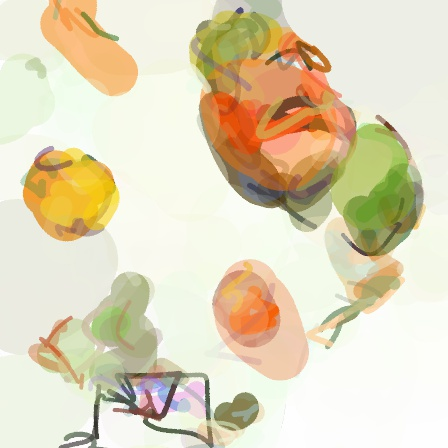

In [ ]:
prompt = 'A man is watching TV'
style = 'https://raw.githubusercontent.com/pschaldenbrand/StyleCLIPDraw/master/images/fruit.jpg'

with torch.no_grad():
    text_features = model.encode_text(clip.tokenize(prompt).to(device))
normalize = transforms.Compose([
    transforms.Resize(224),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])
best_img_clip_score, best_img = 999999, None
for _ in range(4):
    img  = style_clip_draw(prompt, style, debug=False)
    # show_img(img)
    result = torch.from_numpy(img).unsqueeze(0).to(device)
    image_features = model.encode_image(normalize(result))
    loss = -1.* torch.cosine_similarity(text_features, image_features[0:1], dim=1).item()
    if loss < best_img_clip_score:
        best_img_clip_score = loss
        best_img = pil_to_np(img)
print('Best of 4 runs:')
show_img(best_img)

## Slow Version
Below is the slower version of the algorithm.  Results are generally a little better in terms of style.

In [ ]:
#@title style_clip_draw_slow() Definition

def style_clip_draw_slow(prompt, style_path, \
                    num_paths=256, num_iter=1000, max_width=50,\
                    num_augs=4, style_opt_freq=5, style_opt_iter=50,
                    neg_prompt=None, neg_prompt_2=None,\
                    use_normalized_clip=False,
                    debug=False):
    '''
    Perform StyleCLIPDraw using a given text prompt and style image
    args:
        prompt (str) : Text prompt to draw
        style_path(str) : Style image path or url
    kwargs:
        num_paths (int) : Number of brush strokes
        num_iter(int) : Number of optimization iterations
        max_width(float) : Maximum width of a brush stroke in pixels
        num_augs(int) : Number of image augmentations
        style_opt_freq(int) : How often to do style optimization. Low value is high frequency
        style_opt_iter(int) : How many iterations to do in the style optimization loop
        neg_prompt(str) : Negative prompt. None if you don't want it
        neg_prompt_2(str) : Negative prompt. None if you don't want it
        use_normalized_clip(bool)
        debug(bool) : Print intermediate canvases and losses for debugging
    return
        np.ndarray(canvas_height, canvas_width, 3)
    '''
    text_input = clip.tokenize(prompt).to(device)

    if neg_prompt is not None: text_input_neg1 = clip.tokenize(neg_prompt).to(device)
    if neg_prompt_2 is not None: text_input_neg2 = clip.tokenize(neg_prompt_2).to(device)

    # Calculate features
    with torch.no_grad():
        text_features = model.encode_text(text_input)
        if neg_prompt is not None: text_features_neg1 = model.encode_text(text_input_neg1)
        if neg_prompt_2 is not None: text_features_neg2 = model.encode_text(text_input_neg2)

    canvas_width, canvas_height = 224, 224

    # Image Augmentation Transformation
    augment_trans = get_image_augmentation(use_normalized_clip)

    # Initialize Random Curves
    shapes, shape_groups = initialize_curves(num_paths, canvas_width, canvas_height)

    points_vars = []
    stroke_width_vars = []
    color_vars = []
    for path in shapes:
        path.points.requires_grad = True
        points_vars.append(path.points)
        path.stroke_width.requires_grad = True
        stroke_width_vars.append(path.stroke_width)
    for group in shape_groups:
        group.stroke_color.requires_grad = True
        color_vars.append(group.stroke_color)

    # Optimizers
    points_optim = torch.optim.Adam(points_vars, lr=1.0)
    width_optim = torch.optim.Adam(stroke_width_vars, lr=0.1)
    color_optim = torch.optim.Adam(color_vars, lr=0.01)

    # points_vars = [l.data.requires_grad_() for l in points_vars]
    points_optim_style = torch.optim.RMSprop(points_vars, lr=0.1)
    width_optim_style = torch.optim.RMSprop(stroke_width_vars, lr=0.1)
    color_optim_style = torch.optim.RMSprop(color_vars, lr=0.01)

    style_pil = pil_loader(style_path) if os.path.exists(style_path) else pil_loader_internet(style_path)
    style_pil = pil_resize_long_edge_to(style_pil, canvas_width)
    style_np = pil_to_np(style_pil)
    style = (np_to_tensor(style_np, "normal").to(device)+1)/2
    extractor = Vgg16_Extractor(space="normal").to(device)

    # Extract style features from style image
    feat_style = None
    for i in range(5):
        with torch.no_grad():
        # r is region of interest (mask)
            feat_e = extractor.forward_samples_hypercolumn(style, samps=1000)
            feat_style = feat_e if feat_style is None else torch.cat((feat_style, feat_e), dim=2)

    # Run the main optimization loop
    for t in range(num_iter) if debug else tqdm(range(num_iter)):

        # Anneal learning rate (makes videos look cleaner)
        if t == int(num_iter * 0.5):
            for g in points_optim.param_groups:
                g['lr'] = 0.4
        if t == int(num_iter * 0.75):
            for g in points_optim.param_groups:
                g['lr'] = 0.1
        
        points_optim.zero_grad()
        width_optim.zero_grad()
        color_optim.zero_grad()

        img = render_drawing(shapes, shape_groups, canvas_width, canvas_height, t, save=(t % 5 == 0))

        loss = 0
        img_augs = []
        for n in range(num_augs):
            img_augs.append(augment_trans(img))
        im_batch = torch.cat(img_augs)
        image_features = model.encode_image(im_batch)
        for n in range(num_augs):
            loss -= torch.cosine_similarity(text_features, image_features[n:n+1], dim=1)
            if neg_prompt is not None: loss += torch.cosine_similarity(text_features_neg1, image_features[n:n+1], dim=1) * 0.3
            if neg_prompt_2 is not None: loss += torch.cosine_similarity(text_features_neg2, image_features[n:n+1], dim=1) * 0.3

        loss.backward()
        points_optim.step()
        width_optim.step()
        color_optim.step()
        
        # Do style optimization from time to time and on the last iteration
        if t%style_opt_freq == 0 or (t == num_iter-1):
            img = render_drawing(shapes, shape_groups, canvas_width, canvas_height, t)
            feat_content = extractor(img)

            xx, xy = sample_indices(feat_content[0], feat_style) # 0 to sample over first layer extracted
            for it in range(style_opt_iter):
                styleloss=0
                points_optim_style.zero_grad()
                width_optim_style.zero_grad()
                color_optim_style.zero_grad()

                img = render_drawing(shapes, shape_groups, canvas_width, canvas_height, t)
                feat_content = extractor(img) 

                if it % 1 == 0 and it != 0:
                    np.random.shuffle(xx)
                    np.random.shuffle(xy)

                styleloss = calculate_loss(feat_content, feat_content, feat_style, [xx, xy], 0)

                styleloss.backward()
                points_optim_style.step()
                width_optim_style.step()
                color_optim_style.step()

        for path in shapes:
            path.stroke_width.data.clamp_(1.0, max_width)
        for group in shape_groups:
            group.stroke_color.data.clamp_(0.0, 1.0)

        if t % 50 == 0 and debug:
            img = render_scaled(shapes, shape_groups, canvas_width, canvas_height, t=t)
            show_img(img.detach().cpu().numpy()[0])
            # show_img(torch.cat([img.detach(), img_aug.detach()], axis=3).cpu().numpy()[0])
            print('render loss:', loss.item())
            print('iteration:', t)
            with torch.no_grad():
                im_norm = image_features / image_features.norm(dim=-1, keepdim=True)
                noun_norm = nouns_features / nouns_features.norm(dim=-1, keepdim=True)
                similarity = (100.0 * im_norm @ noun_norm.T).softmax(dim=-1)
                values, indices = similarity[0].topk(5)
                print("\nTop predictions:\n")
                for value, index in zip(values, indices):
                    print(f"{nouns[index]:>16s}: {100 * value.item():.2f}%")
    return render_scaled(shapes, shape_groups, canvas_width, canvas_height,
                         scale_factor=2, t=t).detach().cpu().numpy()[0]


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

100%|██████████| 700/700 [13:57<00:00,  1.20s/it]


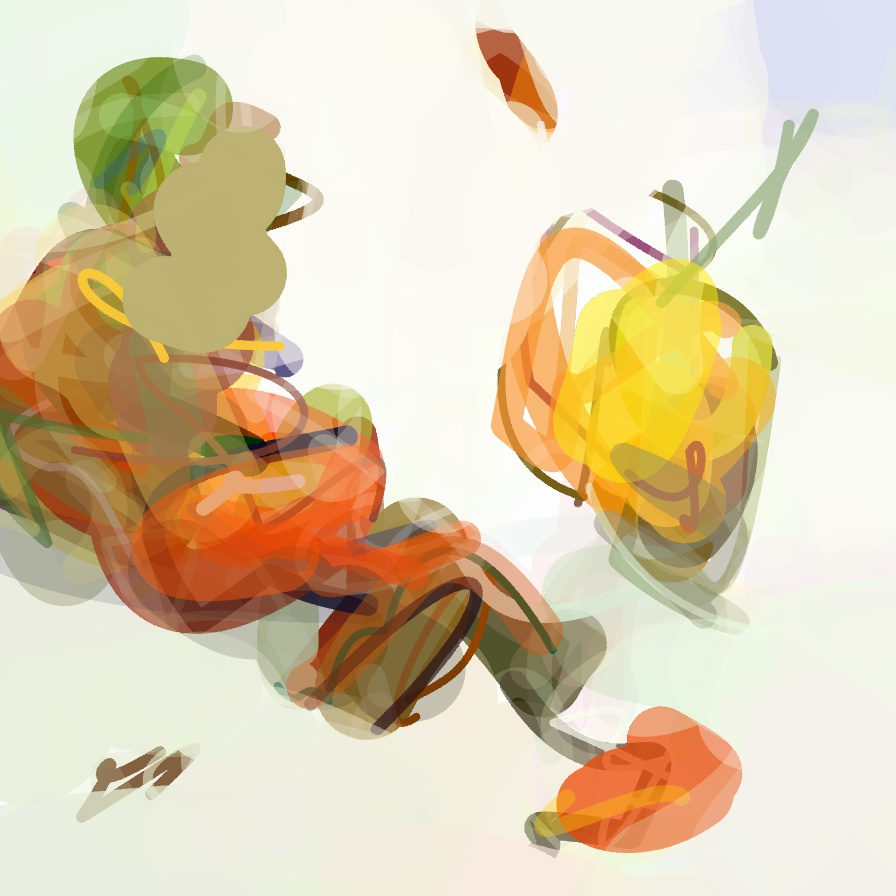

In [ ]:
img = style_clip_draw_slow('A man is watching TV', 'https://raw.githubusercontent.com/pschaldenbrand/StyleCLIPDraw/master/images/fruit.jpg',\
                          num_iter=700, style_opt_freq=5, style_opt_iter=20, debug=False)
show_img(img)

100%|██████████| 700/700 [12:45<00:00,  1.09s/it]


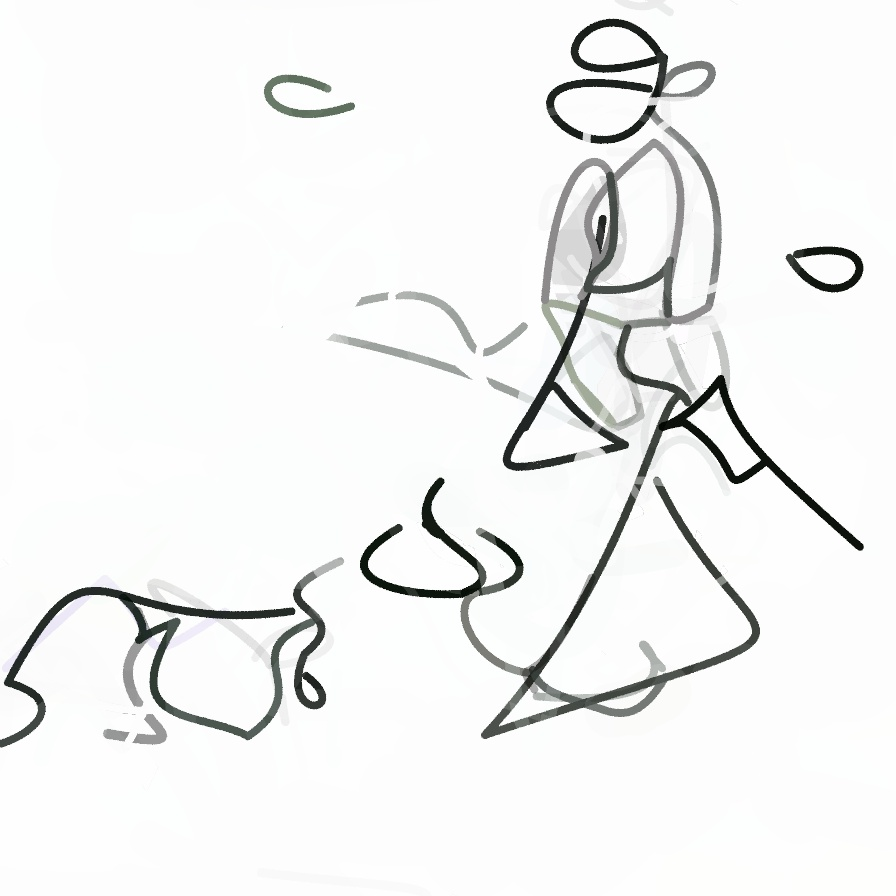

In [ ]:
img = style_clip_draw_slow('A man is walking the dog', 'https://raw.githubusercontent.com/pschaldenbrand/StyleCLIPDraw/master/images/bear.jpg',\
                          num_iter=700, style_opt_freq=5, style_opt_iter=20, debug=False)
show_img(img)

100%|██████████| 700/700 [13:28<00:00,  1.16s/it]


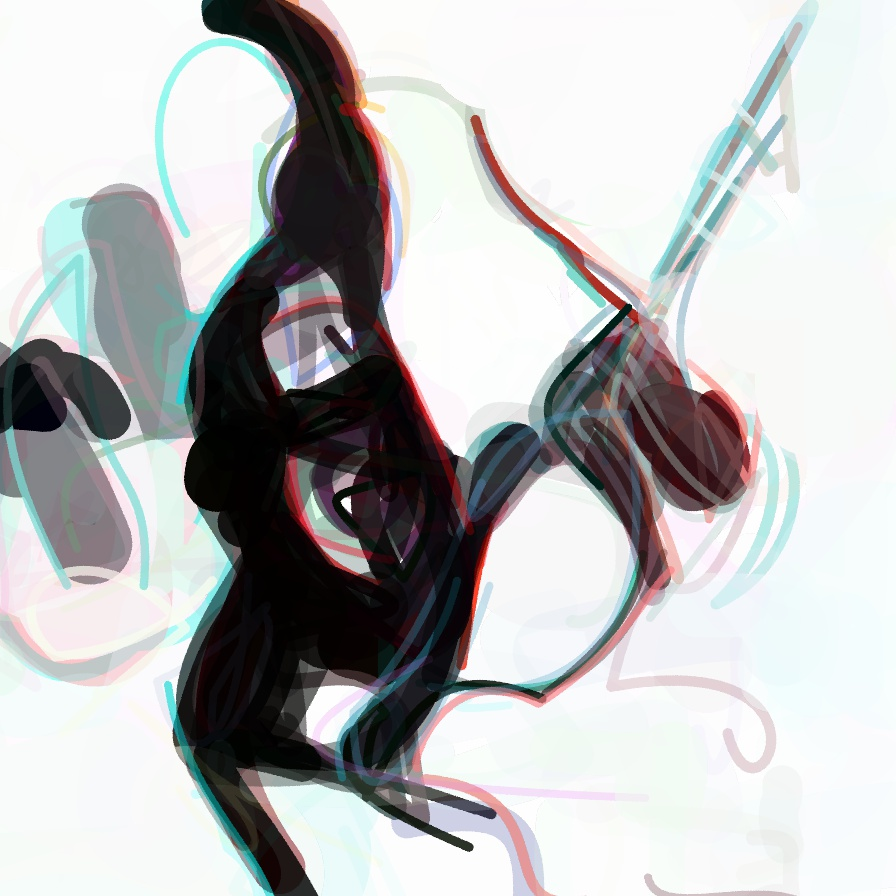

In [ ]:
img = style_clip_draw_slow('A monkey playing guitar', 'https://raw.githubusercontent.com/pschaldenbrand/StyleCLIPDraw/master/images/tiktok.JPG',\
                          num_iter=700, style_opt_freq=5, style_opt_iter=20)
show_img(img)

100%|██████████| 500/500 [08:56<00:00,  1.07s/it]


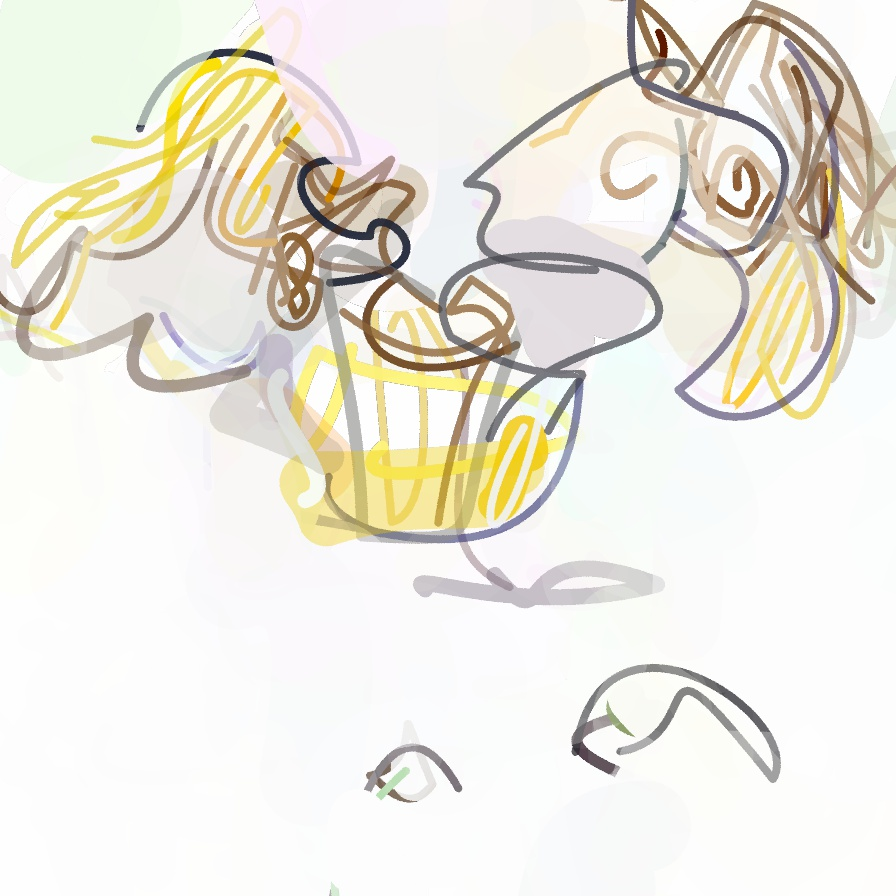

In [ ]:
img = style_clip_draw_slow('A horse eating a cupcake', 'https://raw.githubusercontent.com/pschaldenbrand/StyleCLIPDraw/master/images/lion.jpg',\
                          num_iter=500, style_opt_freq=5, style_opt_iter=20)
show_img(img)